In [8]:
#from modules.utils import sorter, cleaner
from modules.preprocess import loader, sample_print
#from modules. evaluation import train_plot
from keras import models, optimizers

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.regularizers import l2

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

from modules.utils import cleaner, sorter

import os, shutil

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import random


In [2]:
[cleaner(i) for i in ["train","test","validation"]]

print(len(os.listdir("data/raw/knives")))
print(len(os.listdir("data/raw/pistols")))
#print(len(os.listdir("data/cooked/train")))
#print(len(os.listdir("data/cooked/test")))
#print(len(os.listdir("data/cooked/validation")))


5062
7771


In [144]:
print(len(os.listdir("data/cooked/validation")))


3


In [15]:
def sorter_k(train_size, test_size, valid_size):
    # iterate over the files in the folders, split depending on the pre-set tresholds 
    for cat in ["pistols", "knives"]:
        totalcount = len(os.listdir("data/raw/knives"))
        for filecount, filename in enumerate(os.listdir("data/raw/"+cat)):
            # if the sum of desired is more than number of pics, this will break
            if filecount < train_size*totalcount:
                src = os.path.join("data/raw/"+cat,filename)
                dst = os.path.join("data/cooked/train/"+cat, filename)
                shutil.copyfile(src,dst)
            elif filecount < (train_size*totalcount + test_size*totalcount):
                src = os.path.join("data/raw/"+cat,filename)
                dst = os.path.join("data/cooked/test/"+cat, filename)
                shutil.copyfile(src,dst)
            elif filecount < (train_size*totalcount + test_size*totalcount + valid_size*totalcount):
                src = os.path.join("data/raw/"+cat,filename)
                dst = os.path.join("data/cooked/validation/"+cat, filename)
                shutil.copyfile(src,dst)

In [47]:

def sorter_k(train_size, test_size, valid_size):
    # iterate over the files in the folders, split depending on the pre-set tresholds 
    for cat in ["pistols", "knives"]:
        totalcount = len(os.listdir("data/raw/knives"))
        for filename in os.listdir("data/raw/"+cat):
            picker = random.randint(1,3)
            # Use picker to randomly assign the images to the folders
            if (len(os.listdir("data/cooked/test/"+cat)) < test_size*totalcount) & (picker == 1):
                src = os.path.join("data/raw/"+cat,filename)
                dst = os.path.join("data/cooked/test/"+cat, filename)
                shutil.copyfile(src,dst)

            elif (len(os.listdir("data/cooked/validation/"+cat)) < valid_size*totalcount) & (picker <= 2):
                src = os.path.join("data/raw/"+cat,filename)
                dst = os.path.join("data/cooked/validation/"+cat, filename)
                shutil.copyfile(src,dst)

            elif (len(os.listdir("data/cooked/train/"+cat)) < train_size*totalcount) & (picker <= 3):
                src = os.path.join("data/raw/"+cat,filename)
                dst = os.path.join("data/cooked/train/"+cat, filename)
                shutil.copyfile(src,dst)


In [49]:
def cleaner_k(folder_name):
    for cat in ["knives","pistols"]:
        # delete the files on the cooked folder before changing the split sizes to avoid duplication & ease of upload
        for file in os.listdir("data/cooked/"+folder_name+"/"+cat):
            os.remove(os.path.join("data/cooked/"+folder_name+"/"+cat, file))

In [50]:
# Use this before pushing to repo

[cleaner_k(i) for i in ["train","test","validation"]]

sorter_k(.6,.2,.2)

In [2]:
print(len(os.listdir("data/raw/knives")))
print(len(os.listdir("data/raw/pistols")))
print(len(os.listdir("data/cooked/train/knives")))
print(len(os.listdir("data/cooked/train/pistols")))


print(len(os.listdir("data/cooked/test/knives")))
print(len(os.listdir("data/cooked/test/pistols")))


print(len(os.listdir("data/cooked/validation/knives")))
print(len(os.listdir("data/cooked/validation/pistols")))

#print(len(os.listdir("data/cooked/test")))
#print(len(os.listdir("data/cooked/validation")))


5062
7771
3036
3038
1013
1013
1013
1013


In [154]:
for i in ["train", "test", "validation"]:
    for j in ["knives", "pistols"]:
        print('Total number of "cooked" images in', i +"/"+ j)
        print(len(os.listdir("data/cooked/"+i+ "/"+j)))

Total number of "cooked" images in train/knives
3036
Total number of "cooked" images in train/pistols
3038
Total number of "cooked" images in test/knives
1013
Total number of "cooked" images in test/pistols
1013
Total number of "cooked" images in validation/knives
1013
Total number of "cooked" images in validation/pistols
1013


In [3]:
train = loader("train",
augmentation = True, 
rotation_range= 45, 
width_shift_range=.2, 
height_shift_range=.2, 
shear_range = 0.2, 
zoom_range = 0.2, 
horizontal_flip = True)

Found 6074 images belonging to 2 classes.


In [4]:
valid = loader("test")
test_set = loader("validation")

Found 2025 images belonging to 2 classes.
Found 2026 images belonging to 2 classes.


In [97]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_set2 = train_datagen.flow_from_directory(("data/cooked/validation"), target_size = (200,200), batch_size = 32, class_mode ='binary',shuffle=False)
valid_set2 = train_datagen.flow_from_directory(("data/cooked/test"), target_size = (200,200), batch_size = 32, class_mode ='binary')


Found 2026 images belonging to 2 classes.
Found 2025 images belonging to 2 classes.


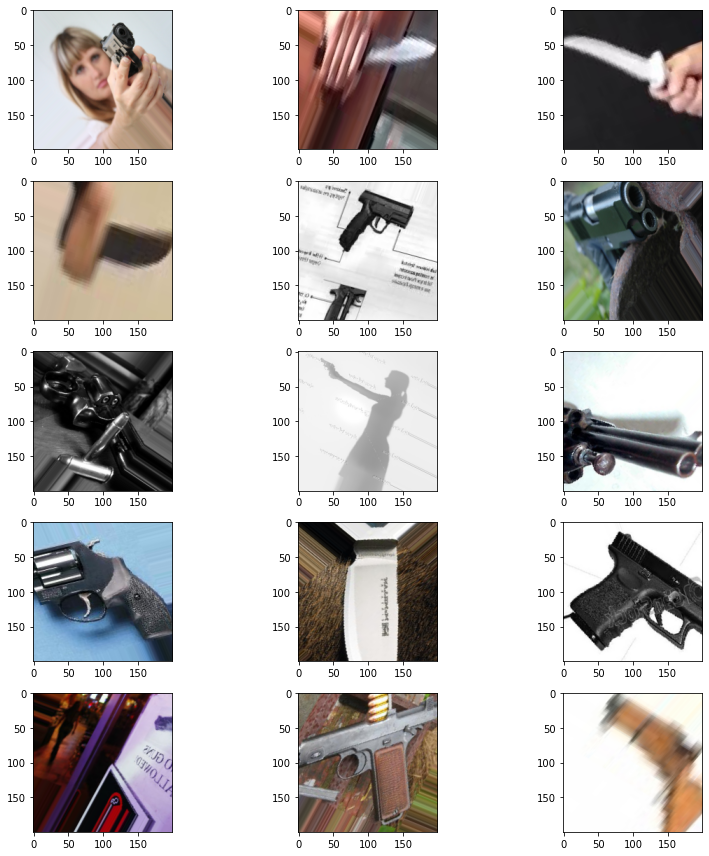

In [54]:
sample_print(train)

## MODELS

In [23]:
# Initialising the CNN
classifier4 = Sequential()

# Step 1 - Convolution
classifier4.add(Conv2D(32, (3, 3), activation = 'relu',  input_shape = (200,200,3)))
classifier4.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier4.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier4.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
classifier4.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier4.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fourth convolutional layer
classifier4.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier4.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier4.add(Flatten())

# Step 3.5 - Dropout
classifier4.add(Dropout(.3))

# Step 4 - Full connection
classifier4.add(Dense(units = 256, activation = 'relu'))
classifier4.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [28]:
history4 = classifier4.fit(
    train,
    steps_per_epoch= 6075 // 32,
    epochs = 10,
    validation_data = valid,
    validation_steps = 2024//32 
)

Epoch 1/10
189/189 [==============================] - 163s 860ms/step - loss: 0.6877 - accuracy: 0.5385 - val_loss: 0.5870 - val_accuracy: 0.7644
Epoch 2/10
189/189 [==============================] - 166s 880ms/step - loss: 0.6360 - accuracy: 0.6594 - val_loss: 0.4800 - val_accuracy: 0.7991
Epoch 3/10
189/189 [==============================] - 166s 879ms/step - loss: 0.5764 - accuracy: 0.6953 - val_loss: 0.4353 - val_accuracy: 0.7971
Epoch 4/10
189/189 [==============================] - 166s 880ms/step - loss: 0.5267 - accuracy: 0.7339 - val_loss: 0.4653 - val_accuracy: 0.7877
Epoch 5/10
189/189 [==============================] - 168s 887ms/step - loss: 0.4793 - accuracy: 0.7735 - val_loss: 0.4114 - val_accuracy: 0.8383
Epoch 6/10
189/189 [==============================] - 170s 897ms/step - loss: 0.4543 - accuracy: 0.7754 - val_loss: 0.3198 - val_accuracy: 0.8547
Epoch 7/10
189/189 [==============================] - 174s 918ms/step - loss: 0.4130 - accuracy: 0.8057 - val_loss: 0.4281 -

In [31]:
classifier4.evaluate(test_set, steps= 2024//32)

63/63 [==============================] - 14s 230ms/step - loss: 0.6149 - accuracy: 0.6662


[0.6148576140403748, 0.6661706566810608]

In [55]:
# Initialising the CNN
classifier5 = Sequential()

# Step 1 - Convolution
classifier5.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', padding='same', input_shape = (200,200,3)))
classifier5.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier5.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation = 'relu'))
classifier5.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
classifier5.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation = 'relu'))
classifier5.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fourth convolutional layer
classifier5.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation = 'relu'))
classifier5.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier5.add(Flatten())

# Step 3.5 - Dropout
classifier5.add(Dropout(.3))

# Step 4 - Full connection
classifier5.add(Dense(units = 128, kernel_initializer='he_uniform', activation = 'relu'))
classifier5.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [56]:
history5 = classifier5.fit(
    train,
    steps_per_epoch= 6075 // 32,
    epochs = 10,
    validation_data = valid,
    validation_steps = 2024//32 
)

Epoch 1/10
189/189 [==============================] - 173s 914ms/step - loss: 0.6623 - accuracy: 0.6879 - val_loss: 0.7483 - val_accuracy: 0.6161
Epoch 2/10
189/189 [==============================] - 177s 938ms/step - loss: 0.4743 - accuracy: 0.7799 - val_loss: 0.5986 - val_accuracy: 0.7078
Epoch 3/10
189/189 [==============================] - 176s 929ms/step - loss: 0.4325 - accuracy: 0.8039 - val_loss: 0.6205 - val_accuracy: 0.7143
Epoch 4/10
189/189 [==============================] - 176s 930ms/step - loss: 0.3789 - accuracy: 0.8398 - val_loss: 0.5897 - val_accuracy: 0.7292
Epoch 5/10
189/189 [==============================] - 177s 936ms/step - loss: 0.3493 - accuracy: 0.8482 - val_loss: 0.4547 - val_accuracy: 0.7937
Epoch 6/10
189/189 [==============================] - 175s 924ms/step - loss: 0.3278 - accuracy: 0.8649 - val_loss: 0.4297 - val_accuracy: 0.8145
Epoch 7/10
189/189 [==============================] - 178s 943ms/step - loss: 0.3154 - accuracy: 0.8631 - val_loss: 0.4679 -

In [57]:
classifier5.evaluate(test_set, steps= 2024//32)

63/63 [==============================] - 21s 335ms/step - loss: 0.4131 - accuracy: 0.8180


[0.4130873382091522, 0.8179563283920288]

> 87.216


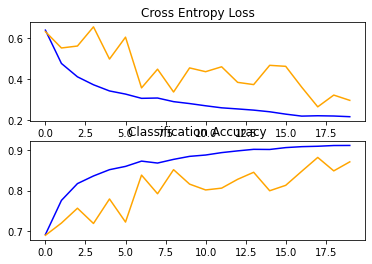

In [9]:
# define cnn model
def define_model():
    # Initialising the CNN
    classifier5 = Sequential()

    # Step 1 - Convolution
    classifier5.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', padding='same', input_shape = (200,200,3)))
    classifier5.add(MaxPooling2D(pool_size = (2, 2)))

    # Adding a second convolutional layer
    classifier5.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation = 'relu'))
    classifier5.add(MaxPooling2D(pool_size = (2, 2)))

    # Adding a third convolutional layer
    classifier5.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation = 'relu'))
    classifier5.add(MaxPooling2D(pool_size = (2, 2)))

    # Adding a fourth convolutional layer
    classifier5.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation = 'relu'))
    classifier5.add(MaxPooling2D(pool_size = (2, 2)))

    # Step 3 - Flattening
    classifier5.add(Flatten())

    # Step 3.5 - Dropout
    classifier5.add(Dropout(.3))

    # Step 4 - Full connection
    classifier5.add(Dense(units = 128, kernel_initializer='he_uniform', activation = 'relu'))
    classifier5.add(Dense(units = 1, activation = 'sigmoid'))

    # Compiling the CNN
    classifier5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return classifier5

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	#filename = sys.argv[0].split('/')[-1]
	#pyplot.savefig(filename + '_plot.png')
	#pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generators
	#train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		#width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	#test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	#train_it = train_datagen.flow_from_directory('data/cooked/train/',
		#class_mode='binary', batch_size=64, target_size=(200, 200))
	#test_it = test_datagen.flow_from_directory('data/cooked/test/',
		#class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit(train, steps_per_epoch=len(train),
		validation_data=valid, validation_steps=len(valid), epochs=20, verbose=0)
	# evaluate model
	_, acc = model.evaluate(test_set, steps=len(test_set), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

In [12]:
# Initialising the CNN
the_model = Sequential()

# Step 1 - Convolution
the_model.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', padding='same', input_shape = (200,200,3)))
the_model.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
the_model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation = 'relu'))
the_model.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
the_model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation = 'relu'))
the_model.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fourth convolutional layer
the_model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation = 'relu'))
the_model.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
the_model.add(Flatten())

# Step 3.5 - Dropout
the_model.add(Dropout(.3))

# Step 4 - Full connection
the_model.add(Dense(units = 128, kernel_initializer='he_uniform', activation = 'relu'))
the_model.add(Dense(units = 1, activation = 'sigmoid'))

# Step 5 - Prepare Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Compiling the CNN
the_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [13]:
the_history = the_model.fit(
    train,
    steps_per_epoch= len(train),
    epochs = 50,
    validation_data = valid,
    validation_steps = len(valid),
    callbacks=[es, mc],
)

Epoch 1/50
190/190 [==============================] - ETA: 0s - loss: 0.6860 - accuracy: 0.6605
Epoch 00001: val_accuracy improved from -inf to 0.61827, saving model to best_model.hdf5
190/190 [==============================] - 154s 809ms/step - loss: 0.6860 - accuracy: 0.6605 - val_loss: 0.7011 - val_accuracy: 0.6183
Epoch 2/50
190/190 [==============================] - ETA: 0s - loss: 0.4824 - accuracy: 0.7687
Epoch 00002: val_accuracy improved from 0.61827 to 0.72840, saving model to best_model.hdf5
190/190 [==============================] - 151s 796ms/step - loss: 0.4824 - accuracy: 0.7687 - val_loss: 0.5835 - val_accuracy: 0.7284
Epoch 3/50
190/190 [==============================] - ETA: 0s - loss: 0.4241 - accuracy: 0.8039
Epoch 00003: val_accuracy did not improve from 0.72840
190/190 [==============================] - 152s 800ms/step - loss: 0.4241 - accuracy: 0.8039 - val_loss: 0.5882 - val_accuracy: 0.7235
Epoch 4/50
190/190 [==============================] - ETA: 0s - loss: 0

In [14]:
from keras.models import load_model

modelk = load_model("best_model.hdf5")

In [15]:
modelk.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 128)      

In [16]:
modelk.evaluate(test_set, steps=len(test_set))

64/64 [==============================] - 16s 246ms/step - loss: 0.3726 - accuracy: 0.8258


[0.37261882424354553, 0.825765073299408]

In [ ]:
# PREDICT & CLASSIFICATION REPORT
Y_pred = (modelk.predict(test_set) > 0.5).astype("int32")

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))

print('Classification Report')
target_names = ['Pistols', 'Others']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

In [58]:
xb, yb = test_set[3]
plt.imshow(xb[0])
plt.show()

In [93]:
modelk.evaluate(test_set2)

64/64 [==============================] - 16s 246ms/step - loss: 0.3726 - accuracy: 0.8258


[0.3726188838481903, 0.825765073299408]

In [98]:
Y_pred = modelk.predict(test_set2, 2026//32) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['Knives', 'Pistols']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))


Confusion Matrix
[[738 275]
 [ 78 935]]
Classification Report
              precision    recall  f1-score   support

        Cats       0.90      0.73      0.81      1013
        Dogs       0.77      0.92      0.84      1013

    accuracy                           0.83      2026
   macro avg       0.84      0.83      0.82      2026
weighted avg       0.84      0.83      0.82      2026



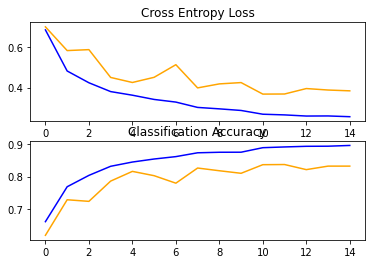

In [100]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(the_history.history['loss'], color='blue', label='train')
plt.plot(the_history.history['val_loss'], color='orange', label='test')
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(the_history.history['accuracy'], color='blue', label='train')
plt.plot(the_history.history['val_accuracy'], color='orange', label='test')

## TRIALS ON THE BEST MODEL YET (MODELK)

In [117]:
## TRIAL 1 - No Dropout

# Initialising the CNN
modelk2 = Sequential()

# Step 1 - Convolution
modelk2.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', padding='same', input_shape = (200,200,3)))
modelk2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
modelk2.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation = 'relu'))
modelk2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
modelk2.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation = 'relu'))
modelk2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fourth convolutional layer
modelk2.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation = 'relu'))
modelk2.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
modelk2.add(Flatten())

# Step 3.5 - Dropout
#modelk2.add(Dropout(.3))

# Step 4 - Full connection
modelk2.add(Dense(units = 128, kernel_initializer='he_uniform', activation = 'relu'))
modelk2.add(Dense(units = 1, activation = 'sigmoid'))

# Step 5 - Prepare Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Compiling the CNN
modelk2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [104]:
historyk2 = modelk2.fit(
    train,
    steps_per_epoch= len(train),
    epochs = 10,
    validation_data = valid,
    validation_steps = len(valid),
    callbacks=[es, mc],
)

Epoch 1/10
190/190 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.6745
Epoch 00001: val_accuracy improved from -inf to 0.69333, saving model to best_model.hdf5
190/190 [==============================] - 155s 818ms/step - loss: 0.6804 - accuracy: 0.6745 - val_loss: 0.6209 - val_accuracy: 0.6933
Epoch 2/10
190/190 [==============================] - ETA: 0s - loss: 0.4755 - accuracy: 0.7769
Epoch 00002: val_accuracy improved from 0.69333 to 0.74370, saving model to best_model.hdf5
190/190 [==============================] - 150s 791ms/step - loss: 0.4755 - accuracy: 0.7769 - val_loss: 0.5213 - val_accuracy: 0.7437
Epoch 3/10
190/190 [==============================] - ETA: 0s - loss: 0.4355 - accuracy: 0.7990
Epoch 00003: val_accuracy improved from 0.74370 to 0.79802, saving model to best_model.hdf5
190/190 [==============================] - 149s 786ms/step - loss: 0.4355 - accuracy: 0.7990 - val_loss: 0.4556 - val_accuracy: 0.7980
Epoch 4/10
190/190 [==============

In [116]:
## TRIAL 2 - No Dropout & 5 Conv Layers

# Initialising the CNN
modelk3 = Sequential()

# Step 1 - Convolution
modelk3.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_normal', padding='same', input_shape = (200,200,3)))
modelk3.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
modelk3.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same', activation = 'relu'))
modelk3.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
modelk3.add(Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same', activation = 'relu'))
modelk3.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fourth convolutional layer
modelk3.add(Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same', activation = 'relu'))
modelk3.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fifth convolutional layer
modelk3.add(Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same', activation = 'relu'))
modelk3.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
modelk3.add(Flatten())

# Step 3.5 - Dropout
#modelk3.add(Dropout(.3))

# Step 4 - Full connection
modelk3.add(Dense(units = 128, kernel_initializer='he_normal', activation = 'relu'))
modelk3.add(Dense(units = 1, activation = 'sigmoid'))

# Step 5 - Prepare Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model3.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Compiling the CNN
modelk3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [106]:
historyk3 = modelk3.fit(
    train,
    steps_per_epoch= len(train),
    epochs = 50  
    validation_data = valid,
    validation_steps = len(valid),
    callbacks=[es],
)

Epoch 1/10
190/190 [==============================] - 164s 861ms/step - loss: 0.6609 - accuracy: 0.6678 - val_loss: 0.6875 - val_accuracy: 0.6000
Epoch 2/10
190/190 [==============================] - 152s 798ms/step - loss: 0.4716 - accuracy: 0.7774 - val_loss: 0.6371 - val_accuracy: 0.6553
Epoch 3/10
190/190 [==============================] - 152s 799ms/step - loss: 0.4300 - accuracy: 0.7985 - val_loss: 0.5147 - val_accuracy: 0.7812
Epoch 4/10
190/190 [==============================] - 152s 800ms/step - loss: 0.3711 - accuracy: 0.8400 - val_loss: 0.5236 - val_accuracy: 0.7669
Epoch 5/10
190/190 [==============================] - 152s 801ms/step - loss: 0.3508 - accuracy: 0.8513 - val_loss: 0.4035 - val_accuracy: 0.8178
Epoch 6/10
190/190 [==============================] - 152s 802ms/step - loss: 0.3358 - accuracy: 0.8614 - val_loss: 0.5044 - val_accuracy: 0.7778
Epoch 7/10
190/190 [==============================] - 151s 794ms/step - loss: 0.3030 - accuracy: 0.8704 - val_loss: 0.4377 -

In [110]:
## TRIAL 2 - No Dropout & 5 Conv Layers & Kernel Regularizer in Conv Layers

# Initialising the CNN
modelk4 = Sequential()

# Step 1 - Convolution
modelk4.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01), padding='same', input_shape = (200,200,3)))
modelk4.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
modelk4.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', kernel_regularizer=l2(0.01), padding='same', activation = 'relu'))
modelk4.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
modelk4.add(Conv2D(128, (3, 3), kernel_initializer='he_normal', kernel_regularizer=l2(0.01), padding='same', activation = 'relu'))
modelk4.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fourth convolutional layer
modelk4.add(Conv2D(128, (3, 3), kernel_initializer='he_normal', kernel_regularizer=l2(0.01), padding='same', activation = 'relu'))
modelk4.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fifth convolutional layer
modelk4.add(Conv2D(128, (3, 3), kernel_initializer='he_normal', kernel_regularizer=l2(0.01), padding='same', activation = 'relu'))
modelk4.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
modelk4.add(Flatten())

# Step 3.5 - Dropout
#modelk4.add(Dropout(.3))

# Step 4 - Full connection
modelk4.add(Dense(units = 128, kernel_initializer='he_normal', activation = 'relu'))
modelk4.add(Dense(units = 1, activation = 'sigmoid'))

# Step 5 - Prepare Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Compiling the CNN
modelk4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [112]:
mc2 = ModelCheckpoint('best_modell2.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

historyk4 = modelk4.fit(
    train,
    steps_per_epoch= len(train),
    epochs = 20,
    validation_data = valid,
    validation_steps = len(valid),
    callbacks=[es, mc2],
)

Epoch 1/20
190/190 [==============================] - ETA: 0s - loss: 3.9039 - accuracy: 0.6762
Epoch 00001: val_accuracy improved from -inf to 0.69630, saving model to best_modell2.hdf5
190/190 [==============================] - 154s 812ms/step - loss: 3.9039 - accuracy: 0.6762 - val_loss: 1.8373 - val_accuracy: 0.6963
Epoch 2/20
190/190 [==============================] - ETA: 0s - loss: 1.3809 - accuracy: 0.7563
Epoch 00002: val_accuracy improved from 0.69630 to 0.70914, saving model to best_modell2.hdf5
190/190 [==============================] - 153s 806ms/step - loss: 1.3809 - accuracy: 0.7563 - val_loss: 1.1944 - val_accuracy: 0.7091
Epoch 3/20
190/190 [==============================] - ETA: 0s - loss: 0.9936 - accuracy: 0.7703
Epoch 00003: val_accuracy improved from 0.70914 to 0.74074, saving model to best_modell2.hdf5
190/190 [==============================] - 153s 806ms/step - loss: 0.9936 - accuracy: 0.7703 - val_loss: 0.9500 - val_accuracy: 0.7407
Epoch 4/20
190/190 [========

In [115]:
history_final = modelk3.fit(
    train,
    steps_per_epoch= len(train),
    epochs = 50,  
    validation_data = valid,
    validation_steps = len(valid),
    callbacks=[es, mc],
)

Epoch 1/50
190/190 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.7086
Epoch 00001: val_accuracy improved from -inf to 0.70815, saving model to best_model3.hdf5
190/190 [==============================] - 155s 817ms/step - loss: 0.5919 - accuracy: 0.7086 - val_loss: 0.6518 - val_accuracy: 0.7081
Epoch 2/50
190/190 [==============================] - ETA: 0s - loss: 0.4662 - accuracy: 0.7837
Epoch 00002: val_accuracy did not improve from 0.70815
190/190 [==============================] - 152s 801ms/step - loss: 0.4662 - accuracy: 0.7837 - val_loss: 0.6877 - val_accuracy: 0.6578
Epoch 3/50
190/190 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8284
Epoch 00003: val_accuracy improved from 0.70815 to 0.80395, saving model to best_model3.hdf5
190/190 [==============================] - 152s 799ms/step - loss: 0.3895 - accuracy: 0.8284 - val_loss: 0.4394 - val_accuracy: 0.8040
Epoch 4/50
190/190 [==============================] - ETA: 0s - loss:

KeyboardInterrupt: 

In [119]:
history_final2 = modelk2.fit(
    train,
    steps_per_epoch= len(train),
    epochs = 50,  
    validation_data = valid,
    validation_steps = len(valid),
    callbacks=[es, mc],
)

Epoch 1/50
190/190 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.6818
Epoch 00001: val_accuracy improved from -inf to 0.67605, saving model to best_model.hdf5
190/190 [==============================] - 153s 807ms/step - loss: 0.6817 - accuracy: 0.6818 - val_loss: 0.6068 - val_accuracy: 0.6760
Epoch 2/50
190/190 [==============================] - ETA: 0s - loss: 0.4621 - accuracy: 0.7850
Epoch 00002: val_accuracy improved from 0.67605 to 0.72741, saving model to best_model.hdf5
190/190 [==============================] - 150s 788ms/step - loss: 0.4621 - accuracy: 0.7850 - val_loss: 0.5611 - val_accuracy: 0.7274
Epoch 3/50
190/190 [==============================] - ETA: 0s - loss: 0.4032 - accuracy: 0.8210
Epoch 00003: val_accuracy improved from 0.72741 to 0.76247, saving model to best_model.hdf5
190/190 [==============================] - 150s 788ms/step - loss: 0.4032 - accuracy: 0.8210 - val_loss: 0.5213 - val_accuracy: 0.7625
Epoch 4/50
190/190 [==============

In [120]:
modelk2.evaluate(test_set, steps=len(test_set))

64/64 [==============================] - 16s 254ms/step - loss: 0.3382 - accuracy: 0.8430


[0.33818602561950684, 0.8430404663085938]

In [121]:
Y_pred = modelk2.predict(test_set2, 2026//32) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['Knives', 'Pistols']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))


Confusion Matrix
[[749 264]
 [ 54 959]]
Classification Report
              precision    recall  f1-score   support

      Knives       0.93      0.74      0.82      1013
     Pistols       0.78      0.95      0.86      1013

    accuracy                           0.84      2026
   macro avg       0.86      0.84      0.84      2026
weighted avg       0.86      0.84      0.84      2026



In [123]:
from kerastuner.tuners import RandomSearch

In [125]:
def model_fitter(model, epochs, train, valid, callbacks=None):
    return model.fit(train, steps_per_epoch=len(train), epochs=epochs, validation_data=valid, validation_steps=len(valid), callbacks=callbacks)

In [ ]:
testhistory = model_fitter(modelk2,2,train,valid)

In [ ]:
def model_predictor(model,testset):
    preds = model.predict(testset, len(testset))
    Y_pred = (Y_pred>0.5)
    print('Confusion Matrix')
    print(confusion_matrix(test_set.classes, Y_pred))
    print('Classification Report')
    target_names = ['Knives', 'Pistols']
    print(classification_report(test_set.classes, Y_pred, target_names=target_names))


In [132]:
modelk2.add(Conv2D(32, ker))

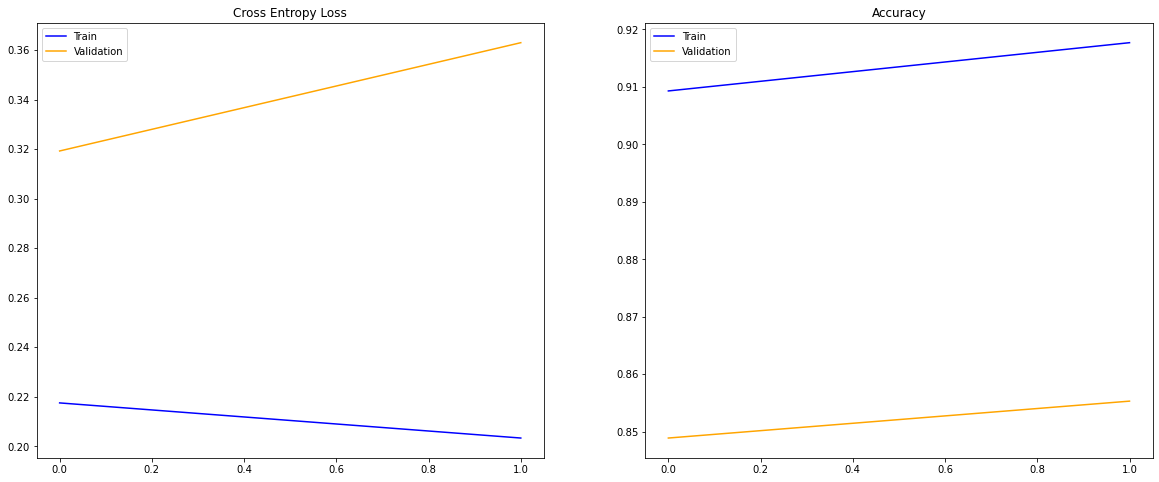

In [140]:
def hist_acc(hist):
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.title("Cross Entropy Loss")
    plt.plot(hist.history["loss"], color="blue", label="Train")
    plt.plot(hist.history["val_loss"], color="orange", label="Validation")
    plt.legend()

    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(hist.history["accuracy"], color="blue", label="Train")
    plt.plot(hist.history["val_accuracy"], color="orange", label="Validation")
    plt.legend()
    plt.show()


In [143]:
hist_acc(testhistory)

In [142]:
def model_predictor(model,testset):
    preds = model.predict(testset, len(testset))
    preds = (preds>0.5)
    print('Confusion Matrix')
    print(confusion_matrix(test_set.classes, preds))
    print('Classification Report')
    target_names = ['Knives', 'Pistols']
    print(classification_report(test_set.classes, preds, target_names=target_names))

Confusion Matrix


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U21'), dtype('<U21')) -> dtype('<U21')

In [155]:
model_predictor(modelk2,test_set2)

In [156]:
from modules.utils import sorter, cleaner
from modules.kerasfns import create_model, model_fitter, pred_perf, hist_acc
from modules.preprocess import loader, sample_print

Epoch 1/10
190/190 [==============================] - 140s 739ms/step - loss: 0.6171 - accuracy: 0.6709 - val_loss: 0.6502 - val_accuracy: 0.6607
Epoch 2/10
190/190 [==============================] - 141s 740ms/step - loss: 0.4661 - accuracy: 0.7810 - val_loss: 0.5724 - val_accuracy: 0.7091
Epoch 3/10
190/190 [==============================] - 139s 730ms/step - loss: 0.4294 - accuracy: 0.8057 - val_loss: 0.4797 - val_accuracy: 0.7817
Epoch 4/10
190/190 [==============================] - 141s 744ms/step - loss: 0.3868 - accuracy: 0.8308 - val_loss: 0.5308 - val_accuracy: 0.7684
Epoch 5/10
190/190 [==============================] - 142s 746ms/step - loss: 0.3666 - accuracy: 0.8405 - val_loss: 0.4052 - val_accuracy: 0.8178
Epoch 6/10
190/190 [==============================] - 142s 746ms/step - loss: 0.3490 - accuracy: 0.8523 - val_loss: 0.4304 - val_accuracy: 0.8000
Epoch 7/10
190/190 [==============================] - 141s 743ms/step - loss: 0.3222 - accuracy: 0.8648 - val_loss: 0.3753 -

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [157]:
# Trial #1 - Creating the base model
model1 = create_model([32,64,128], dropout=True)
hist1, model1v = model_fitter(model1,10,train,valid)
pred_perf(model1v,test_set)

Confusion Matrix
[[635 378]
 [ 44 969]]
Classification Report
              precision    recall  f1-score   support

      Knives       0.94      0.63      0.75      1013
     Pistols       0.72      0.96      0.82      1013

    accuracy                           0.79      2026
   macro avg       0.83      0.79      0.79      2026
weighted avg       0.83      0.79      0.79      2026



array([[False],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])